In [1]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;


In [2]:
# Import relevant packages.
using DataFrames
using CSV
using ProgressBars
using StatsPlots


In [3]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);



In [4]:
# We will call a deposit_address to every address that has deposited in Tcash
CSV.write("../data/deposit_addresses.csv", deposit_transactions_df[!, [:from_address]] |> unique)
# We will call a withdraw_address to every address that has withdrawal from Tcash
CSV.write("../data/withdraw_addresses.csv", withdraw_transactions_df[!, [:recipient_address]] |> unique)



"../data/withdraw_addresses.csv"

In [5]:
deposit_transactions_df

,Column1,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address
,Int64,Int64,String,Int64,Int64,String,String,Float64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String
1,0,0,0xcf97c470a56d96625c7240d3004ae2abd9141d7ffc4383ab6f29a181e3562e8b,4,10,0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,56000000000,1677906,1048832,missing,missing,1,2020-11-02 17:47:30 UTC,11179130,0x21d86cba454fea4f7e43c68763d4cffec101b614554635a3f15d538049463d4f,missing,missing,missing,56000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d
2,1,1,0x2fadc4d54bf6e3ec5035f14c0096befe92999866309893e0eeaecdef955c0323,22,118,0x6e92bc493c6abbdd6a1b18416f003de2c873ab50,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,63000000000,8209080,1048832,missing,missing,1,2021-01-02 23:37:35 UTC,11578054,0xd52ababd1dbbbe50277c54473c881f47fd95e78081a349670d4988644e4d37c4,missing,missing,missing,63000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d
3,2,10,0x7baf0a76f35c1dece97fff883aa7174454bed460b1bade05844080017170fc6c,240,171,0x8c4c44fd06f7f98f08bf6a9ca156cec9ee1f31f8,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,0.0,800000,105000000000,10723996,800000,missing,missing,0,2021-01-06 19:04:40 UTC,11602841,0x7c5f21ea2a92f5182ce8648f152b6fb3b4379096309dc2ba232ac663c4a0d1d7,missing,missing,missing,105000000000,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144
4,3,11,0x7f851ba1d7292ca565961073a1111f7408760540c6f94e479c72a2ae05399cf4,0,84,0x50b9d4af009b038506d4d84b035c451d1a3a20bc,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,5000000000,8465851,800000,missing,missing,0,2020-01-05 05:19:39 UTC,9218451,0x77e0fc60906714a54697cfd9275b622ad9d2d0271c4ec816b10fa3a09b103680,missing,missing,missing,5000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
5,4,12,0xbd83053f8afa7777f54a4aca6b8e112fa31b888922dc5b9a9a65eb66e9a6996f,7,63,0x6c6e4816ecfa4481472ff88f32a3e00f2eaa95a1,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,30838446643,6222489,800000,missing,missing,0,2020-05-27 03:30:44 UTC,10145408,0x837b3482443f027f6f045644bf002243f72304686015a2d6265676b2a2fc630b,missing,missing,missing,30838446643,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
6,5,14,0x76b09da7f41e24cba38a1e6685c1e59e7eeb476b6ba037c117a7507c7893d997,17,192,0x23480df691dbf7c62e967952bbf2067c18cc2f16,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,0.0,1200000,20000000000,10862643,1009408,missing,missing,1,2020-07-14 22:31:59 UTC,10460353,0x5fb59dbf5a00a59e074b3157380ed5cf0cf25db54023d9e030fe752fcbffd1bd,missing,missing,missing,20000000000,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144
7,6,65,0x28d7c0e186ba6e0fee6606821edce1b67c8efbc28fa9649226a36d884dbbb31e,34,122,0x5ba446670288149052645705618f121af76dd19d,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,100000,105000000000,11286350,99841,missing,missing,0,2020-09-23 18:37:27 UTC,10920500,0x5e10e5e65d15b9c79ebd8c3975d06a024565e8e4ae33b335527335677c4f0a7b,missing,missing,missing,105000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
8,7,129,0x31cde8a6a7027377d821fd3e90b41ef5d07578b8a6e2127c65a2f6bdb0186375,447,16,0xd0698d231d4b65b97a3df9c16aafda8d9b0bda41,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,0.0,1200000,99000000000,2127258,992258,missing,missing,1,2020-10-29 17:08:33 UTC,11152937,0x96aec1cd89b9e37fbeacca4a0ee33d6c2c71d02e3fd02b754fd78b8f4e7ce8fa,missing,missing,missing,99000000000,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f
9,8,130,0xba7d56fea776705a937d912674cc56cf3ea71485c8fb6995d1c2ec00d44645fc,2,69,0x3a456bc9083bfe147719504aee8f296eb7355ee1,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,0.0,1200000,100000000000,4634190,992258,missing,missing,1,2020-08-15 11:34:23 UTC,10664413,0x4075362cd93950

In [6]:
# Lets load the transactions_of_deposit_addresses, a dataframe that contains 
# all the transactions between a deposit address and a linked address
transactions_of_deposit_addresses =  CSV.read("../data/transactions_between_deposit_and_withdraw_addresses.csv", DataFrame)


,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
,Int64,String,Int64,Int64,String,String,Float64,Int64,Int64,Int64,Int64,Missing,String?,Float64?,String,Int64,String,Float64?,Float64?,Float64?,Int64
1,0,0x95a985c3cdb846eb9e681b4a5504252476a4526533194ff55e188c6a287faea5,660,445,0xde33e58f056ff0f23be3ef83ab6e1e0bec95506f,0x0000000000811324e341265fb81e635119b32a27,6.10651e17,21000,315458825961,24173642,21000,missing,missing,1.0,2021-09-07 16:06:46+00:00,13179623,0xed5a7fb952972ec31d1e4749209ce973c4485a4336955b934fb8ef9e656a0dae,3.9468e11,5.05627e9,2.0,315458825961
2,1,0x2283052990d67e9edb413680a586bd21c73ad89a9c127eee4298dadd8636f3ec,1679,212,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,36620109608,18840054,21000,missing,missing,1.0,2021-08-18 21:46:47+00:00,13051722,0x49275b4abd649d6e7809d4cb6f706ed5202793c488145cbab5e0cd9bbed5c798,5.09882e10,4.0e9,2.0,36620109608
3,2,0x6060a52af5acb6e94b576cd17610946228c54ca41a1f547c159bda7260277e5f,1994,265,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,233851350688,13924789,21000,missing,missing,1.0,2021-11-02 01:29:41+00:00,13534695,0x4f281a72e3f4ac513ae9c3bbe217e1ee7989c62b2606e2ce95e9914eeb892e90,2.82298e11,2.425e9,2.0,233851350688
4,3,0x6d75a599e245fcc41f7918a82a1cfb306e7785eabe515d0887a70b040421b881,1996,267,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,233851350688,13966789,21000,missing,missing,1.0,2021-11-02 01:29:41+00:00,13534695,0x4f281a72e3f4ac513ae9c3bbe217e1ee7989c62b2606e2ce95e9914eeb892e90,2.82298e11,2.425e9,2.0,233851350688
5,4,0x19ef65dab5504b0489c89cd9a31d348111bfe25d5a1bbb1367b1777b154acaac,1581,92,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,1462996670392,29943331,21000,missing,missing,1.0,2021-08-15 19:05:19+00:00,13031548,0x7ff94f67fd4a7895cb3e87c03377a906363164b817078373c77314b01fd7142f,1.463e12,1.33813e12,2.0,1462996670392
6,5,0x08c6d7f02cfa25e2a5ea793a6e626a5cebd851f7cded076d3eb82789dd12518a,1908,127,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,1000000,90522296947,9060649,21000,missing,missing,1.0,2021-10-01 17:16:32+00:00,13334772,0xdf6cd671bca9f2c1a1cbf1e4ce88e32e70cb026a9ae85f38af95d5d07a96e2b3,1.08182e11,1.65e9,2.0,90522296947
7,6,0xe0e369f1593a55d7ee95f8c898884f4af87d940d00e9d66daa6d7ec3307e78fa,1984,75,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,200783732420,3930653,21000,missing,missing,1.0,2021-11-01 23:49:48+00:00,13534229,0x2aa0e35e62b93f7fc7ccad5ae19e366ca2eb461b7b25a78625c26737eb179fc5,3.168e11,5.0e9,2.0,200783732420
8,7,0x20e2f0d3bd9e12acab8a54df7689fcc48a772b6ade7f65e2aad7737b7e132900,594,235,0xe747c2d98e21de4f170fb65e84e8fa2f840c6e1c,0x00000000009a41862f3b2b0c688b7c0d1940511e,9.0e17,21000,59403534848,18922499,21000,missing,missing,1.0,2021-09-17 05:10:16+00:00,13241285,0x467e4c66a9bffa546ba36fba3522fd5c4bd112c8c8de80c1a6dcabcd4c0455e5,8.11239e10,1.65e9,2.0,59403534848
9,8,0xd3be837eec2a704069ee6119609f7195bd1c3f6a8e7485b2fe51181288166adb,1734,135,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,65715134533,11751359,21000,missing,missing,1.0,2021-08-29 02:24:01+00:00,13117679,0xb0a249f48d2d7a4c66a4110e2def1a2901836ddfc50744876be075939348caab,7.0e10,5.0e8,2.0,65715134533


### function linked_transactions_heuristic
The input DataFrame `transactions_of_deposit_addresses` contain transactions that involve deposit_addresees.
We want to link the input `withdraw_transaction` with a transaction inside the `transactions_of_deposit_addresses`. So, the  `linked_transactions_heuristic` function retuns all the transactions inside the `transactions_of_deposit_addresses` that involve the `withdraw_transaction.recipient_address` and where made before `withdraw_transaction.block_timestamp` 

Important: The input `transactions_of_deposit_addresses` must be sorted  by the column `block_timestamp` for the function to work.



In [7]:
function linked_transactions_heuristic(transactions_of_deposit_addresses, withdraw_transaction)
    linked_transactions = DataFrame(  withdraw_address = String[], deposit_address = String[], transaction_hash = String[])
        
        # We will iterate over every transaction between a deposit address and a withdraw address.
        # And get the ones between the withdraw_transaction.recipient_address and a deposit address
        for transaction in eachrow(transactions_of_deposit_addresses)
            # Since the transactions_of_deposit_addresses must be sorted, when we find a transaction
            # that was done before the withdraw_transaction.block_timestamp we can stop searching 
            if transaction.block_timestamp > withdraw_transaction.block_timestamp 
                break
            elseif transaction.from_address == withdraw_transaction.recipient_address
                push!(linked_transactions, [withdraw_transaction.recipient_address, transaction.to_address, transaction.hash ])
            elseif transaction.to_address == withdraw_transaction.recipient_address
                push!(linked_transactions, [withdraw_transaction.recipient_address, transaction.from_address, transaction.hash])
            end
        end

    
    return linked_transactions
end


linked_transactions_heuristic (generic function with 1 method)

In [8]:
# Lets test the function
sorted_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp )
sorted_transactions_of_deposit_addresses = sort(transactions_of_deposit_addresses, :block_timestamp )
linked_transactions_heuristic(sorted_transactions_of_deposit_addresses,sorted_withdraw_transactions_df[80700, :])


,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x806e3751307df85158db59247bf43ac4a76dd0854d76ab3a6d6ed37ab440fe63
2,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x7a1f9f767d5737e549a404a1af933b12f4a6f048,0x518239c5c71ba0e2b805e6e8ed39849c30fdad90aaeced8f4867e2784f7d18fd
3,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x8d46fa21b07ea83b9d3baee77fa11055a1e162d21141feb33d1ecd9267e793ae
4,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x3829547cb1cb5154e6753e6832468f74a94adec19bc6bf610d5b003fbc775177
5,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0x450551e229202bc643b3f45df8721b921869bd43f4b0936ae9cbc00b4a450ca0
6,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xbccdc6d1572ce74be0c6836460e0a40bbf8ead07031ec4d3554851e66c94de80
7,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0x0557533e68c813a2bba37ca389233f7618c9327657ccd1cac89ee832dc1be568
8,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x510059633c4958d43dfbc50b3b1a4ce6b9cb871a,0x1743d7077af28de73217ee384aff0532944b47183981ae8184bbfecde1eba728
9,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0x6aa263dd363ba99c433a8a4c9e6bfe8a120662029bf1c545fa11644ad04ce8dc


### function apply_linked_transactions_heuristic
Apply the `linked_transactions_heuristic` function to each withdraw of the input `withdraw_transactions_df` DataFrame.
Retuns a DataFrame with the columns: `withdraw_address`, `deposit_address` and `transaction_hash`.
You can read this DataFrame in the following way:
The `withdraw_address` is linked to the  `deposit_address` by the transaction `transaction_hash`

In [9]:
# Auxiliary function
# Add the new linked transactions we found to the linked_transactions DataFrame
function add_linked_transactions(linked_transactions, new_linked_transactions)
    for transaction in eachrow(new_linked_transactions)
        # Since some addresses are both deposit and  withdrawal addresses,
        # we could be adding the same transaction twice to de linked_transactions DataFrame.
        # With this if we ensure this doesn´t happen
        if transaction.transaction_hash ∉ linked_transactions.transaction_hash
            push!(linked_transactions, transaction)
        end
    end
    return linked_transactions
end
    

add_linked_transactions (generic function with 1 method)

In [10]:
function apply_linked_transactions_heuristic(transactions_of_deposit_addresses, withdraw_transactions_df)
    
    sorted_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp )
    sorted_top_to_bottom_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp, rev = true)
    sorted_transactions_of_deposit_addresses = sort(transactions_of_deposit_addresses, :block_timestamp)
    # To ensure we analizaed every withdraw address just once.
    analyzed_withdraw_addresses = []
    # To store all the linked transactions we found
    linked_transactions = DataFrame(withdraw_address = String[], deposit_address = String[], transaction_hash = String[])
    
    # Iterate over every withdrawal transaction.
    # To optimize this for loop we will use the sorted_top_to_bottom_withdraw_transactions_df
    # So, when we analyzed a withdraw address we ensure that we get the withdraw 
    # with the highest :block_timestamp(see linked_transactions_heuristic function).
    for withdraw_transaction in ProgressBar(eachrow(sorted_top_to_bottom_withdraw_transactions_df), printing_delay= 30)
        # If we haven´t analized the withdraw address yet, we analize it
        if withdraw_transaction.recipient_address ∉ analyzed_withdraw_addresses
            
            # Find all the transactions that the withdraw address has had with any deposit address
            new_linked_transactions = linked_transactions_heuristic(sorted_transactions_of_deposit_addresses, withdraw_transaction)
            
            # Add the new new_linked_transactions founf to the linked_transactions DataFrame
            linked_transactions = add_linked_transactions(linked_transactions, new_linked_transactions)
            
            # Push the to the withdraw_address to the analyzed_withdraw_addresses vector
            push!(analyzed_withdraw_addresses, withdraw_transaction.recipient_address)
        end
    end
    
    return linked_transactions
end

apply_linked_transactions_heuristic (generic function with 1 method)

In [11]:
@time results = apply_linked_transactions_heuristic(transactions_of_deposit_addresses, withdraw_transactions_df)


0.0%┣                                     ┫ 0/83.8k [00:30<-698:-11:00, -30s/it]
0.0%┣                                        ┫ 1/83.8k [00:30<Inf:Inf, InfGs/it]
1.7%┣▊                                        ┫ 1.4k/83.8k [01:00<58:21, 24it/s]
3.9%┣█▋                                       ┫ 3.3k/83.8k [01:30<36:56, 36it/s]
5.4%┣██▏                                      ┫ 4.5k/83.8k [02:00<35:03, 38it/s]
7.1%┣███                                      ┫ 5.9k/83.8k [02:30<32:58, 39it/s]
8.7%┣███▋                                     ┫ 7.3k/83.8k [03:00<31:36, 40it/s]
10.8%┣████▎                                   ┫ 9.0k/83.8k [03:30<29:01, 43it/s]
13.2%┣█████▏                                 ┫ 11.0k/83.8k [04:00<26:28, 46it/s]
15.1%┣██████                                 ┫ 12.7k/83.8k [04:30<25:17, 47it/s]
17.0%┣██████▋                                ┫ 14.2k/83.8k [05:01<24:31, 47it/s]
19.0%┣███████▍                               ┫ 15.9k/83.8k [05:31<23:31, 48it/s]
20.8%┣████████▏             

1002.113935 seconds (18.57 G allocations: 277.041 GiB, 5.01% gc time)


100.0%┣██████████████████████████████████████┫ 83.8k/83.8k [17:10<00:00, 81it/s]


,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0x4718ce007293bce1e514887e6f55ea71d9a992d6,0x40630b4fd61523450b3dbc4d9fd672aae0a9c31c,0xa662eb6e416a85098d2bf285142799f306e8e60e2cb53d5ef70a8fb780f89c0b
2,0x4718ce007293bce1e514887e6f55ea71d9a992d6,0x40630b4fd61523450b3dbc4d9fd672aae0a9c31c,0xd33733271ef17ce5cd9b2c21725d1ada50253792f0b15535d1b1558aaaaeb975
3,0x4718ce007293bce1e514887e6f55ea71d9a992d6,0x40630b4fd61523450b3dbc4d9fd672aae0a9c31c,0xcdebe15b4124ec08d316b51c52f469fcac24eadaa0986bc59e4c1b87d7007c1f
4,0x4718ce007293bce1e514887e6f55ea71d9a992d6,0x40630b4fd61523450b3dbc4d9fd672aae0a9c31c,0x902644f0147e7ba27dacdb103eabf70b18e782d0592d5bcaa58cb84a5c9fd18d
5,0x1aaf2f422f39687459031e6b9a788eccab84d214,0x1db3439a222c519ab44bb1144fc28167b4fa6ee6,0xc3df8939f6bfa3284fd5f3236c3e960ebdce348bfd270e2503a10a0ef11d35ec
6,0x1aaf2f422f39687459031e6b9a788eccab84d214,0x1db3439a222c519ab44bb1144fc28167b4fa6ee6,0x826bef52a3b80c1d4be5b0ab0148946bf8ef79f94c96de68b065a613e7b36628
7,0x1aaf2f422f39687459031e6b9a788eccab84d214,0xd5c6934766998102218fdcc54c88ebd9f492e70e,0xf1edf09b5e25e98c364009a7683352a89ee14c70b3042913c243fff1364d7852
8,0x1aaf2f422f39687459031e6b9a788eccab84d214,0xd5c6934766998102218fdcc54c88ebd9f492e70e,0x92b3006e5da310f1c1422ff740513305505ed9982e577eecef0f371c56567377
9,0x1aaf2f422f39687459031e6b9a788eccab84d214,0x1db3439a222c519ab44bb1144fc28167b4fa6ee6,0xe89848da2b9677f65d699548682b8fe2e0c8bdaa275587b9cb5f031c26600968


Lets inspect the results


In [12]:
groupby_results = sort(combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count), :count, rev = true)

,withdraw_address,deposit_address,count
,String,String,Int64
1,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,4136
2,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,1163
3,0xe5818d70a9b5aed2bfde4e41fbcb07dd80f8fc84,0x9dfac9bbe1119da5dcdd7b095db40920cde878ef,344
4,0x73b687a6cfe7271a31ac563e8703ae787878613c,0xcf701308663a495637f4131f7d3644372e170e5b,281
5,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,271
6,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,231
7,0xa8015df1f65e1f53d491dc1ed35013031ad25034,0x8298c072baa440607c1f83b4024c0b4c47fcd163,231
8,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,197
9,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,171


In [13]:
#CSV.write("../data/third_heruristic_groupby_results.csv", get_linked_addresses(groupby_results))


In [14]:
groupby_results = sort(combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count), :count, rev = true)

,withdraw_address,deposit_address,count
,String,String,Int64
1,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,4136
2,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,1163
3,0xe5818d70a9b5aed2bfde4e41fbcb07dd80f8fc84,0x9dfac9bbe1119da5dcdd7b095db40920cde878ef,344
4,0x73b687a6cfe7271a31ac563e8703ae787878613c,0xcf701308663a495637f4131f7d3644372e170e5b,281
5,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,271
6,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,231
7,0xa8015df1f65e1f53d491dc1ed35013031ad25034,0x8298c072baa440607c1f83b4024c0b4c47fcd163,231
8,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,197
9,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,171


As we can see some withdraw_address have had transactions with more than one deposit_address and vice versa.
We will define that a withdraw_address and a deposit_address are linked, in the cases where the withdraw_address and the deposit_address have had transactions only between them.

For example:

Transaction 1: `deposit_address_1` -> `withdraw_address_1`

Transaction 2: `withdraw_address_1` -> `deposit_address_1`

Transaction 3: `deposit_address_2` -> `withdraw_address_2`

Transaction 4: `withdraw_address_2` -> `deposit_address_2`

Transaction 5: `withdraw_address_2` -> `deposit_address_3`


`deposit_address_1` and `withdraw_address_1` will be consider  linked.
`deposit_address_2` wont be linked to `deposit_address_2`, since withdraw_address_2 has had a transaction with  `deposit_address_3`



In [15]:
# Auxiliary functions 
# Checks if the given address is unique in the input column
function is_unique(address, column)
    return findall(row -> row == address, column ) |> length == 1 
end


is_unique (generic function with 1 method)

In [16]:
function get_linked_addresses(results)
    groupby_results = combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count)
    withdraw_addresses = groupby_results[!, :withdraw_address]
    deposit_addresses = groupby_results[!, :deposit_address]
    linked_addresses = Dict()
    for row ∈ eachrow(groupby_results)
        if is_unique(row.withdraw_address, withdraw_addresses) && is_unique(row.deposit_address, deposit_addresses)
            linked_addresses[row.withdraw_address] = row.deposit_address
        end
    end
    return linked_addresses
end



get_linked_addresses (generic function with 1 method)

In [17]:
get_linked_addresses(results)


Dict{Any, Any} with 1727 entries:
  "0x3ff88ea59c108da5bac14d8bb87f1e6c22f6ee0d" => "0xaa018113d42ab7c467f383ef69400d083d5e0906"
  "0xf10de86fc53fb40b87bb1782982e90365716dc22" => "0xf10de86fc53fb40b87bb1782982e90365716dc22"
  "0xcd438d3ac0b8d7490a716570f34e727a5f8f43c9" => "0xcd438d3ac0b8d7490a716570f34e727a5f8f43c9"
  "0x374aac8eb9296dd7953886be03913e5da7fdc6e8" => "0xfda6640e4614d79d4673135656a8e82d5588d9a4"
  "0x882c34e0a3405f713581b8c8c9650f3cc28df488" => "0x882c34e0a3405f713581b8c8c9650f3cc28df488"
  ⋮                                            => ⋮

In [18]:
CSV.write("../data/third_heruristic_linked_addresses.csv",get_linked_addresses(results))

"../data/third_heruristic_linked_addresses.csv"

### Results visualization


In [22]:
function get_histogram_data(results, withdraw_transactions_df)
    groupby_results = combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count)
    withdraw_addresses = withdraw_transactions_df[!, [:recipient_address]] |> unique |> Matrix
    linked_addresses = Dict()
    
    for withdraw_address in withdraw_addresses
        linked_addresses[withdraw_address] = 0
    end
    
    for row ∈ eachrow(groupby_results)
            linked_addresses[row.withdraw_address] += 1
    end
    
    return linked_addresses
end


get_histogram_data (generic function with 1 method)

In [20]:
get_histogram_data(results, withdraw_transactions_df)


Dict{Any, Any} with 32528 entries:
  "0xab17da946b4ee971e6cd95f9784d664c074c1eae" => 0
  "0x3db8a6a96a8e3711c30c84d5bc26971ef61c549d" => 0
  "0x5d57f2e5f61b484eadc146fe245ff67cceb24497" => 0
  "0xce41f28db174e9684c84a1edcfddbebeaa22729d" => 0
  "0xe8c4d0b45cae962ea5fab9f797f49124c7e2d8ca" => 0
  ⋮                                            => ⋮

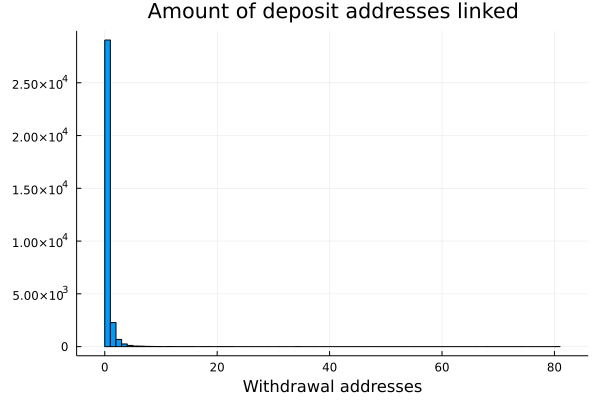

In [24]:
result_values = values(get_histogram_data(results, withdraw_transactions_df)) |> collect
histogram(result_values, bins= maximum(result_values) ,legend=false, title="Amount of deposit addresses linked", xlabel="Withdrawal addresses")
